In [28]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import OrderedDict
from sklearn.cluster import KMeans
sns.set(style="darkgrid")

from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier

# classifiers
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

# evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from scipy.stats import chisquare, chi2_contingency

In [29]:
# load datasest
df = pd.read_excel("./data/IgM-IgG_ELISA_Rapid_Test_Symptoms.xlsx", header=0, comment="#")
len(df)

106

In [30]:
df["IgG/Rt "] = df["IgG/Rt "].replace("N", 0)

In [31]:
df

,lab-ID,Gender,Age,IgM/Rt,IgM/ODs,IgG/Rt,IgG/ODs,Sym. grade,Symptoms
0,LSS-1,M,54,10,0.383,100.0,0.447,1.0,"Headache, sorethroat"
1,LSS-2,F,45,0,0.425,0.0,0.335,0.0,no
2,LSS-3,F,37,0,0.363,0.0,0.655,2.0,"Fatigue, headache, abdominal pain, diarrhoea"
3,LSS-4,M,40,0,0.498,0.0,0.305,0.0,no
4,LSS-5,M,50,0,0.363,10.0,0.334,0.0,no
...,...,...,...,...,...,...,...,...,...
101,HSS-102,F,40,0,0.560,0.0,0.875,1.0,"Sorthroat, headache"
102,HSS-103,F,37,5,0.318,10.0,1.044,1.0,Sorthroat
103,HSS-104,F,60,0,0.651,0.0,0.635,0.0,no
104,HSS-105,M,50,100,NaN,NaN,NaN,2.0,"Fatigue, abdominal pain, anosmia, headache, di..."


In [32]:
# further cleanup
indexNames = df[df['Age'] == 'NS'].index
 
# Delete these row indexes from dataFrame
df.drop(indexNames , inplace=True)

# set age to numeric
df["Age"] = df["Age"].astype(int)

# bin ages
df["Age bin"] = pd.cut(x=df['Age'], 
                       bins=[10, 20, 29, 39, 49, 59, 69, 79, 89], 
                       labels=['10s', '20s', '30s', '40s', '50s','60s', '70s', '80s'])

# remove unwanted spaces

#df[" IgM/Pos."] = df[" IgM/Pos."].str.replace(' ', '')

# remove empty cells
df = df.dropna(axis=0)
len(df)

89

In [33]:
# create class column
def get_class(row):
    wanted = row["lab-ID"]
    return wanted.split("-")[0]

df["status"] = df.apply(get_class, axis=1)

# create target column
def encode_symptoms(row):
    wanted = row["Symptoms"]
    if str(wanted) == "no":
        return 0
    return 1

df["target"] = df.apply(encode_symptoms, axis=1)


# create target column
def encode_symptoms(row):
    wanted = row["Symptoms"]
    if str(wanted) == "no":
        return "no"
    return "yes"

df["symptoms_presence"] = df.apply(encode_symptoms, axis=1)

<ipython-input-33-1c34afd9088b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["status"] = df.apply(get_class, axis=1)
<ipython-input-33-1c34afd9088b>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["target"] = df.apply(encode_symptoms, axis=1)
<ipython-input-33-1c34afd9088b>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

In [34]:
# Classify status

high_od_IgM = df[df["IgM/ODs"] > 0.498]
low_od_IgM = df[df["IgM/ODs"] <= 0.498]
high_od_IgG = df[df["IgG/ODs"] > 0.542]
low_od_IgG = df[df["IgG/ODs"] <= 0.542]

print("status | number_of_participants")
print("--------------------------")
print(f"high_od_IgM | {len(high_od_IgM)}")
print("--------------------------")
print(f"low_od_IgM | {len(low_od_IgM)}")
print("--------------------------")
print(f"high_od_IgG | {len(high_od_IgG)}")
print("--------------------------")
print(f"low_od_IgG | {len(low_od_IgG)}")




status | number_of_participants
--------------------------
high_od_IgM | 17
--------------------------
low_od_IgM | 72
--------------------------
high_od_IgG | 58
--------------------------
low_od_IgG | 31


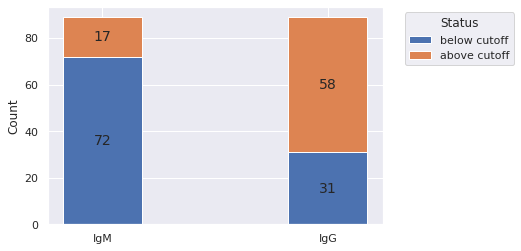

In [35]:
labels = ['IgM', 'IgG']
high = [len(high_od_IgM), len(high_od_IgG)]
low = [len(low_od_IgM), len(low_od_IgG)]
width = 0.35 


fig, ax = plt.subplots()

ax.bar(labels, low, width,
       label='below cutoff')
ax.bar(labels, high, width, bottom=low, label='above cutoff')
ax.set_ylabel('Count')
ax.legend(title='Status', bbox_to_anchor=(1.05, 1), loc='upper left')

for i, rect in enumerate(ax.patches):
    # Find where everything is located
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()

    # The height of the bar is the count value and can used as the label
    label_text = f'{height:.0f}'

    label_x = x + width / 2
    label_y = y + height / 2

    # don't include label if it's equivalently 0
    if height > 0.001:
        ax.text(label_x, label_y, label_text, ha='center', va='center', fontsize=14)

plt.show()

In [36]:
def plot_symptoms_status(df_slice):
    count_dict = dict(df_slice["symptoms_presence"].value_counts())
    ax = sns.countplot(x="symptoms_presence", data=df_slice, order=["no", "yes"])
   # ax.legend(title='Symptoms presence', bbox_to_anchor=(1.05, 1), loc='upper left')
    for index, text in enumerate(ax.get_xticklabels()):
        label = count_dict[text.get_text()]
        ax.text(index,
                label + 0.1,
                str(label),
                horizontalalignment='center',
                size='medium',
                color='black',
                weight='normal')
    return plt.show()
    

High od IgM


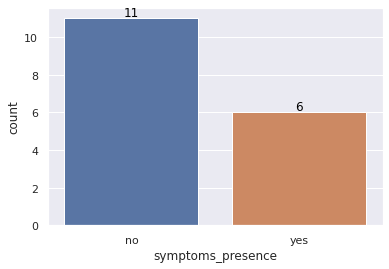

In [37]:
# symptoms status in high od IgM particpants
print("High od IgM")
plot_symptoms_status(high_od_IgM)


High od IgG


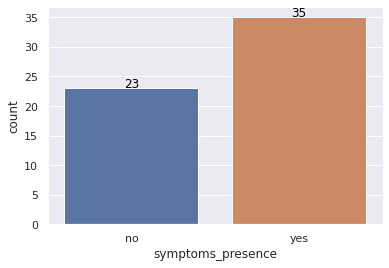

In [38]:
# symptoms status in high od IgG particpants
print("High od IgG")
plot_symptoms_status(high_od_IgG)

low od IgM


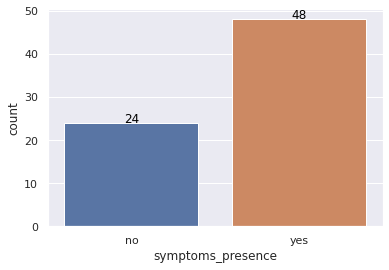

In [39]:
# symptoms status in low od IgM particpants
print("low od IgM")
plot_symptoms_status(low_od_IgM)

low od IgG


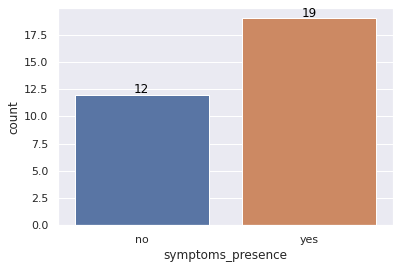

In [40]:
# symptoms status in low od IgG particpants
print("low od IgG")
plot_symptoms_status(low_od_IgG)

In [41]:
# create target 
targets = df["target"].values

# bulk encodings

wanted_columns = ["Gender", "status",
                  "Age bin"]
df_wanted = df[wanted_columns]

le = LabelEncoder()
df_wanted_le = df_wanted.apply(le.fit_transform)
df_wanted_le["IgG_ELISA"] = df["IgG/ODs"]
df_wanted_le["IgM_ELISA"] = df["IgM/ODs"]
df_wanted_le["IgM_rapid_test"] = df["IgM/Rt "]
#df_wanted_le["IgG_rapid_test"] = df["IgG/Rt "]


# Generate training and test sets wiht label encoding

X_train, X_test, y_train, y_test = train_test_split(df_wanted_le,
                                                    targets,
                                                    random_state=42)

# Benchmark with dummy classifier

dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train, y_train)
print("dummmy score: {}".format(dummy_clf.score(X_test, y_test)))

# Random forest model

model = RandomForestClassifier(n_jobs=2, random_state=42)
model.fit(X_train, y_train)
print("RF accuracy: {}".format(model.score(X_test, y_test)))

dummmy score: 0.391304347826087
RF accuracy: 0.5652173913043478


<AxesSubplot:>

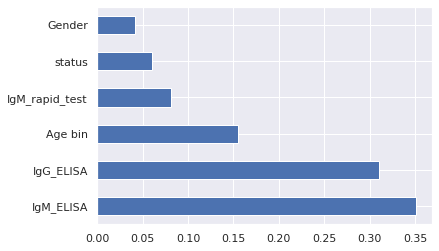

In [42]:
# plot feature contribution to Random forest model
importance = pd.Series(model.feature_importances_, index=df_wanted_le.columns)
importance.nlargest(6).plot(kind='barh')

In [43]:
# Set up different classifiers with label encoder

names = ["K-Nearest Neighbors", "Naive Bayes", "Linear SVM", "RBF SVM", 
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost"]

classifiers = [
    KNeighborsClassifier(),
    GaussianNB(),
    SVC(kernel="linear", C=0.025),
    SVC(gamma="scale", C=1),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    MLPClassifier(),
    AdaBoostClassifier()]

# Compare different classifiers

for name, clf in zip(names, classifiers):
    model = clf
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    report = classification_report(y_test, y_pred)
    print("###### " + name + " #######")
    print("accuracy: {}".format(accuracy))
    print("report:")
    print(report)
    print("------------------------------\n")


###### K-Nearest Neighbors #######
accuracy: 0.5217391304347826
report:
              precision    recall  f1-score   support

           0       0.29      0.25      0.27         8
           1       0.62      0.67      0.65        15

    accuracy                           0.52        23
   macro avg       0.46      0.46      0.46        23
weighted avg       0.51      0.52      0.51        23

------------------------------

###### Naive Bayes #######
accuracy: 0.5652173913043478
report:
              precision    recall  f1-score   support

           0       0.43      0.75      0.55         8
           1       0.78      0.47      0.58        15

    accuracy                           0.57        23
   macro avg       0.60      0.61      0.56        23
weighted avg       0.66      0.57      0.57        23

------------------------------

###### Linear SVM #######
accuracy: 0.6521739130434783
report:
              precision    recall  f1-score   support

           0       0.00     

/nix/store/b7sq43xpybfygir4905ah8gbdidkmabv-python3.9-scikit-learn-0.24.1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/nix/store/b7sq43xpybfygir4905ah8gbdidkmabv-python3.9-scikit-learn-0.24.1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/nix/store/b7sq43xpybfygir4905ah8gbdidkmabv-python3.9-scikit-learn-0.24.1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicte

###### Random Forest #######
accuracy: 0.4782608695652174
report:
              precision    recall  f1-score   support

           0       0.33      0.50      0.40         8
           1       0.64      0.47      0.54        15

    accuracy                           0.48        23
   macro avg       0.48      0.48      0.47        23
weighted avg       0.53      0.48      0.49        23

------------------------------

###### Neural Net #######
accuracy: 0.5652173913043478
report:
              precision    recall  f1-score   support

           0       0.40      0.50      0.44         8
           1       0.69      0.60      0.64        15

    accuracy                           0.57        23
   macro avg       0.55      0.55      0.54        23
weighted avg       0.59      0.57      0.57        23

------------------------------

###### AdaBoost #######
accuracy: 0.5217391304347826
report:
              precision    recall  f1-score   support

           0       0.38      0.62    

/nix/store/b7sq43xpybfygir4905ah8gbdidkmabv-python3.9-scikit-learn-0.24.1/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [44]:
# Generate training and test sets with one-hot encoding

wanted_columns = ["Gender", "status",
                  "Age bin"]
df_wanted = df[wanted_columns]

le = LabelEncoder()
df_wanted_le = df_wanted.apply(le.fit_transform)
ohe = OneHotEncoder()
ohe.fit(df_wanted_le)
input_df = ohe.transform(df_wanted_le).toarray()
# concatenate arrays
input_df = np.c_[input_df, df[["IgG/ODs","IgM/ODs"]].values]


X_train, X_test, y_train, y_test = train_test_split(input_df,
                                                    targets,
                                                    random_state=42)

# Benchmark with dummy classifier

dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train, y_train)
print("dummmy score: {}".format(dummy_clf.score(X_test, y_test)))

# Random forest model

model = RandomForestClassifier(n_jobs=2, random_state=42)
model.fit(X_train, y_train)
print("RF accuracy: {}".format(model.score(X_test, y_test)))

dummmy score: 0.391304347826087
RF accuracy: 0.43478260869565216


In [45]:
# Set up different classifiers with one-hot encoder

names = ["K-Nearest Neighbors", "Naive Bayes", "Linear SVM", "RBF SVM", 
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost"]

classifiers = [
    KNeighborsClassifier(),
    GaussianNB(),
    SVC(kernel="linear", C=0.025),
    SVC(gamma="scale", C=1),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    MLPClassifier(),
    AdaBoostClassifier()]

# Compare different classifiers

for name, clf in zip(names, classifiers):
    model = clf
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    report = classification_report(y_test, y_pred)
    print("###### " + name + " #######")
    print("accuracy: {}".format(accuracy))
    print("report:")
    print(report)
    print("------------------------------\n")


###### K-Nearest Neighbors #######
accuracy: 0.4782608695652174
report:
              precision    recall  f1-score   support

           0       0.17      0.12      0.14         8
           1       0.59      0.67      0.62        15

    accuracy                           0.48        23
   macro avg       0.38      0.40      0.38        23
weighted avg       0.44      0.48      0.46        23

------------------------------

###### Naive Bayes #######
accuracy: 0.6086956521739131
report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.64      0.93      0.76        15

    accuracy                           0.61        23
   macro avg       0.32      0.47      0.38        23
weighted avg       0.42      0.61      0.49        23

------------------------------

###### Linear SVM #######
accuracy: 0.6521739130434783
report:
              precision    recall  f1-score   support

           0       0.00     

/nix/store/b7sq43xpybfygir4905ah8gbdidkmabv-python3.9-scikit-learn-0.24.1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/nix/store/b7sq43xpybfygir4905ah8gbdidkmabv-python3.9-scikit-learn-0.24.1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/nix/store/b7sq43xpybfygir4905ah8gbdidkmabv-python3.9-scikit-learn-0.24.1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicte

###### Neural Net #######
accuracy: 0.43478260869565216
report:
              precision    recall  f1-score   support

           0       0.22      0.25      0.24         8
           1       0.57      0.53      0.55        15

    accuracy                           0.43        23
   macro avg       0.40      0.39      0.39        23
weighted avg       0.45      0.43      0.44        23

------------------------------

###### AdaBoost #######
accuracy: 0.4782608695652174
report:
              precision    recall  f1-score   support

           0       0.30      0.38      0.33         8
           1       0.62      0.53      0.57        15

    accuracy                           0.48        23
   macro avg       0.46      0.45      0.45        23
weighted avg       0.51      0.48      0.49        23

------------------------------



/nix/store/b7sq43xpybfygir4905ah8gbdidkmabv-python3.9-scikit-learn-0.24.1/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
